# Computing the overall metrics for different pipelines
We Compare the 8x8 bin, bin2cell, enact and xenium segmentation on visium data using simple summary metrics, for example cell count, transcripts per cell, unassigned transcripts and some more.

In this dataset we use the Visium Dataset published by 10X which demonstrated the Visium post Xenium protocol on Lung Cancer Tissue.
It can be found here: link



For this script, I recommend to use the tmp_enact_analysis environment, the yml file can be found in the environments folder. !!!!!

In [12]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

In [13]:

bin_8x8_path = "/srv/gstore/projects/p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_008um/filtered_feature_bc_matrix.h5"

cells_b2c_path = "/srv/gstore/projects/p37785/EzPyzBin2CellApp_2025-06-29--17-56-50/Bin2CellApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cdata.h5ad"
cells_enact_path = "/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"
cells_xseg_path = "/srv/gstore/projects/p1001/EzPyzENACTApp_2025-06-02--15-53-26/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"


In [14]:
adata_bin_8 = sc.read_10x_h5(bin_8x8_path)
adata_cells_b2c = sc.read_h5ad(cells_b2c_path)
adata_cells_enact = sc.read_h5ad(cells_enact_path)
adata_cells_xseg = sc.read_h5ad(cells_xseg_path)

/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
for name, adata in [
    ('bin_8', adata_bin_8),
    ('cells_b2c', adata_cells_b2c),
    ('cells_enact', adata_cells_enact),
    ('cells_xseg', adata_cells_xseg)
]:
    sc.pp.calculate_qc_metrics(adata, inplace=True)

In [16]:
# Prepare data for comparison
datasets = {
    '8x8 bin': adata_bin_8,
    'cells b2c': adata_cells_b2c,
    'cells enact': adata_cells_enact,
    'cells xseg': adata_cells_xseg
}

cell_keys = ['cells b2c', 'cells enact', 'cells xseg']

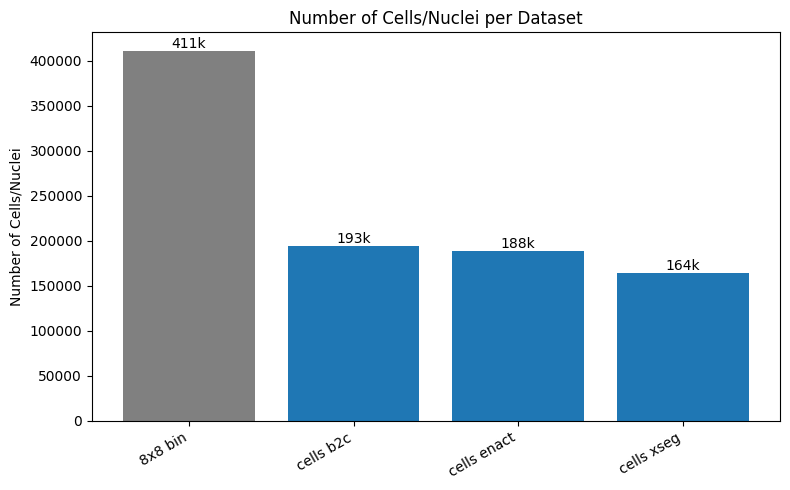

In [17]:
# Plot the number of cells (n_obs) for each dataset
cell_counts = {k: v.n_obs for k, v in datasets.items()}

cell_labels = list(cell_counts.keys())
cell_nums = list(cell_counts.values())
cell_colors = ['gray'] + ['tab:blue']*len(cell_keys)

plt.figure(figsize=(8, 5))
bars = plt.bar(cell_labels, cell_nums, color=cell_colors)
plt.ylabel('Number of Cells/Nuclei')
plt.title('Number of Cells/Nuclei per Dataset')
plt.xticks(rotation=30, ha='right')

# Add rounded numbers (in thousands) on top of bars
for bar, num in zip(bars, cell_nums):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{np.floor(num/1000):.0f}k',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

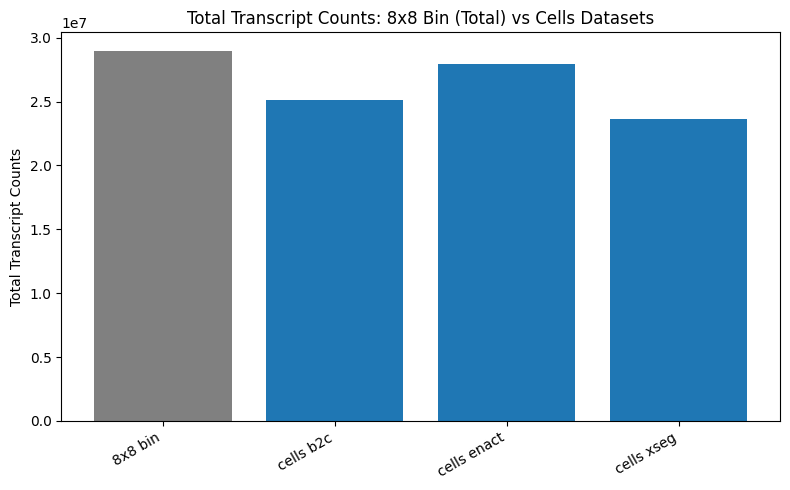

In [18]:
    # Calculate total transcript counts for each dataset
total_counts = {k: v.obs['total_counts'].sum() for k, v in datasets.items()}

# Prepare data for plotting
labels = ['8x8 bin'] + cell_keys
counts = [total_counts['8x8 bin']] + [total_counts[k] for k in cell_keys]
colors = ['gray'] + ['tab:blue']*len(cell_keys)

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color=colors)
plt.ylabel('Total Transcript Counts')
plt.title('Total Transcript Counts: 8x8 Bin (Total) vs Cells Datasets')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

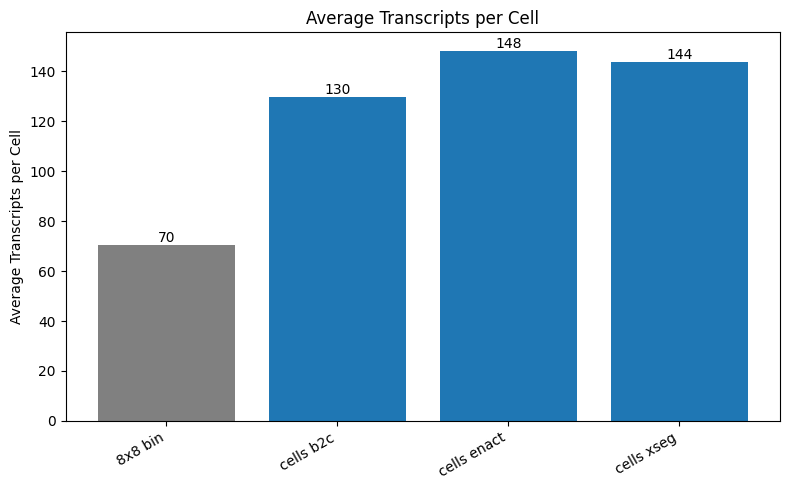

In [19]:
# Calculate average transcripts per cell/nucleus for each dataset
avg_counts = {k: v.obs['total_counts'].mean() for k, v in datasets.items()}

labels = ['8x8 bin'] + cell_keys
avg_values = [avg_counts['8x8 bin']] + [avg_counts[k] for k in cell_keys]
colors = ['gray'] + ['tab:blue']*len(cell_keys)

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, avg_values, color=colors)
plt.ylabel('Average Transcripts per Cell')
plt.title('Average Transcripts per Cell')
plt.xticks(rotation=30, ha='right')

# Add actual values above the bars
for bar, val in zip(bars, avg_values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{val:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

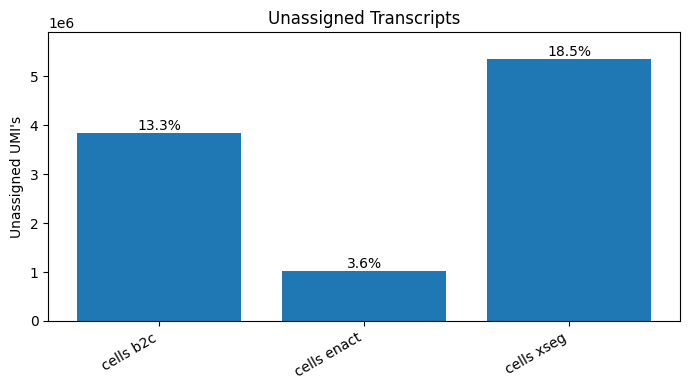

In [20]:
# Calculate unassigned transcripts: difference between bin_8 and each dataset
unassigned_counts = []
unassigned_percents = []
for k in cell_keys:
    diff = total_counts['8x8 bin'] - total_counts[k]
    unassigned_counts.append(diff)
    percent = 100 * diff / total_counts['8x8 bin']
    unassigned_percents.append(percent)

unassigned_labels = cell_keys
unassigned_colors = ['tab:blue']*len(cell_keys)

plt.figure(figsize=(7, 4))
bars = plt.bar(unassigned_labels, unassigned_counts, color=unassigned_colors)
plt.ylabel("Unassigned UMI's")
plt.title('Unassigned Transcripts')
plt.xticks(rotation=30, ha='right')

# Add space above the highest bar
plt.ylim(top=max(unassigned_counts) * 1.10)

# Overlay percentage labels
for bar, pct in zip(bars, unassigned_percents):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

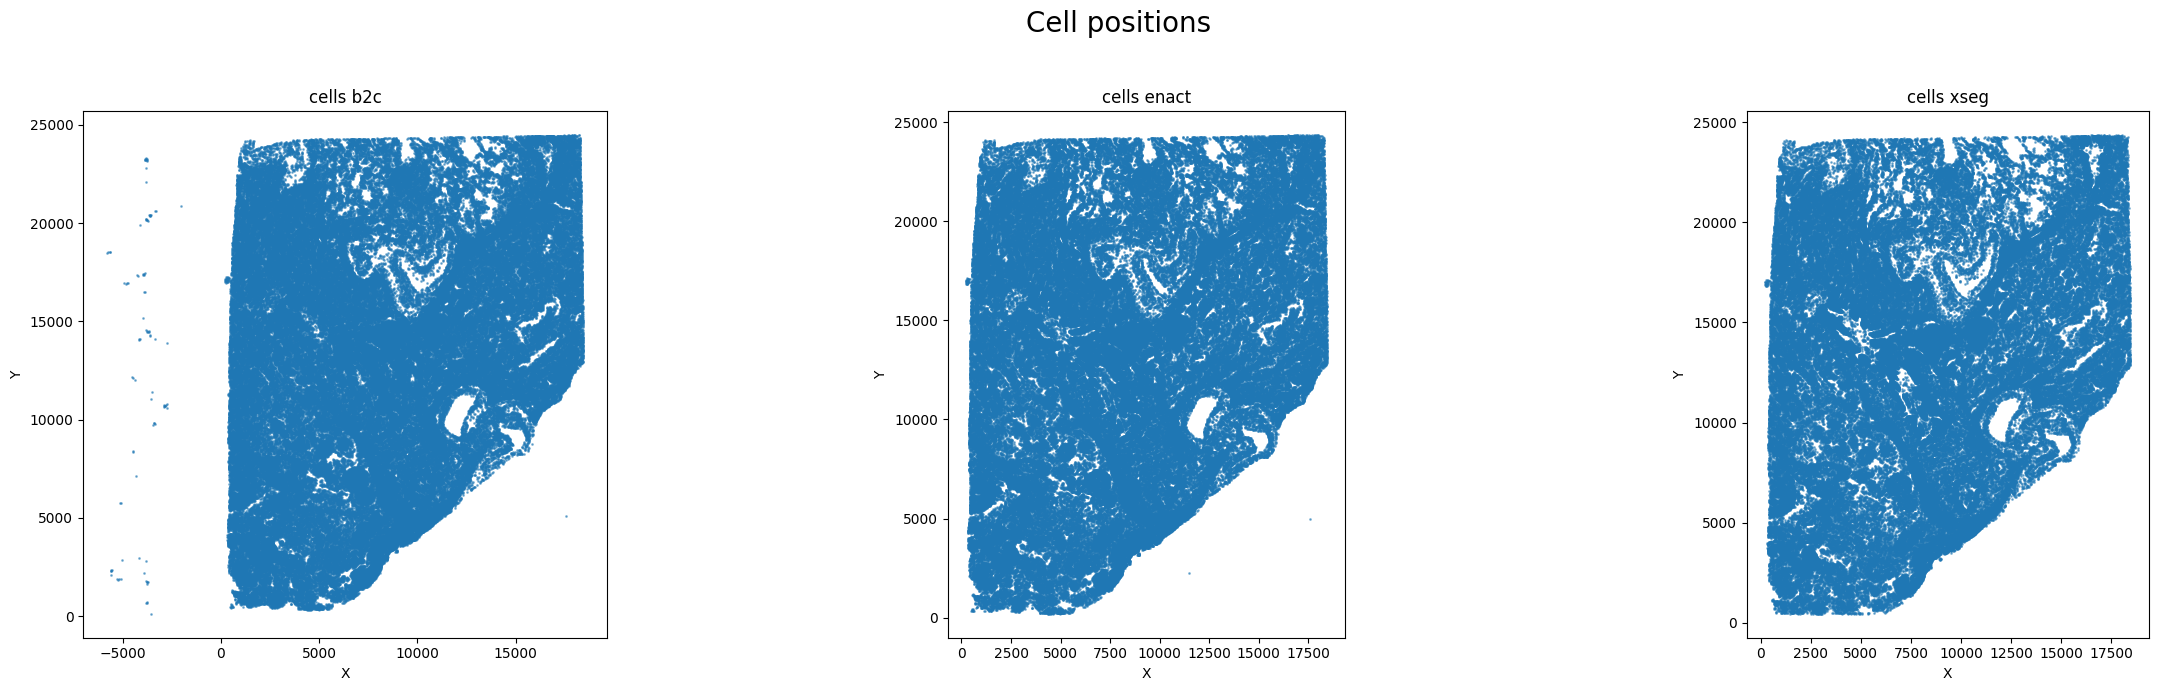

In [21]:
fig, axes = plt.subplots(1, len(cell_keys), figsize=(25, 7), sharex=False, sharey=False)
for ax, key in zip(axes, cell_keys):
    adata = datasets[key]
    coords = adata.obsm['spatial']
    try:
        # Try to use as numpy array (works for AnnData with numpy obsm)
        ax.scatter(coords[:,0], coords[:,1], s=1, alpha=0.5)
    except Exception:
        # If coords is a DataFrame, use column names
        try:
            ax.scatter(coords['cell_x'], coords['cell_y'], s=1, alpha=0.5)
        except Exception:
            # Fallback: try generic .iloc
            ax.scatter(coords.iloc[:,0], coords.iloc[:,1], s=1, alpha=0.5)
    ax.set_title(key)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
fig.suptitle("Cell positions", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()